In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

# Data Filtering Example for FPA Auction Data

## Overview

This notebook demonstrates a suggested approach for filtering data from the FPA (First-Price Auction) data files. The methods shown here are intended as guidelines and can be adapted based on specific requirements.

## Purpose

The main objectives of this notebook are:

1. To showcase a potential data filtering methodology
2. To provide a starting point for working with FPA auction data
3. To replicate the data preprocessing steps applied to the algorithms presented in the benchmark's accompanying research paper, ensuring consistency with the published results

## Important Note

While this notebook presents one way to filter and process the data, it's important to remember that:

- This is not the only correct method
- The approach can and should be modified to suit specific research needs
- Users are encouraged to explore alternative filtering techniques that may be more appropriate for their particular analysis

### Stats and campaigns loading separately

In [5]:
stats = pd.read_csv('../data/fpa/stats.csv')
campaigns = pd.read_csv('../data/fpa/campaigns.csv')

In [6]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176909 entries, 0 to 176908
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   campaign_id               176909 non-null  int64  
 1   period                    176909 non-null  int64  
 2   item_id                   176909 non-null  int64  
 3   contact_price_bin         176909 non-null  float64
 4   AuctionVisibilitySurplus  176909 non-null  float64
 5   AuctionClicksSurplus      176909 non-null  float64
 6   AuctionContactsSurplus    176909 non-null  float64
 7   AuctionWinBidSurplus      176909 non-null  float64
 8   CTRPredicts               176909 non-null  float64
 9   CRPredicts                176909 non-null  float64
 10  AuctionCount              176909 non-null  int64  
 11  platform_p                33878 non-null   object 
dtypes: float64(7), int64(4), object(1)
memory usage: 16.2+ MB


In [7]:
def process_data(campaigns, stats):
    # Filter out invalid or undesirable data points
    stats = stats[
        stats['contact_price_bin'].notna() &
        (stats['AuctionVisibilitySurplus'] > 0) &
        (stats['AuctionClicksSurplus'] > 0) &
        (stats['AuctionContactsSurplus'] > 0) &
        (stats['AuctionWinBidSurplus'] > 0) &
        (stats['CTRPredicts'] > 0) &
        (stats['CRPredicts'] > 0)
    ]

    # Aggregate stats by campaign
    cmp_stats = stats.groupby('campaign_id').agg({
        'period': ['nunique', 'max', 'min'],
        'AuctionWinBidSurplus': 'sum',
        'AuctionContactsSurplus': 'sum',
        'AuctionClicksSurplus': 'sum',
        'contact_price_bin': 'max'
    }).reset_index()

    # Rename columns for clarity
    cmp_stats.columns = ['campaign_id', 'count_periods', 'max_period', 'min_period', 
                         'max_price_vcg', 'AuctionContactsSurplus', 'max_clicks', 'max_contact_price_bin']

    # Calculate FPA max price and max contacts
    cmp_stats['max_price_fpa'] = cmp_stats['AuctionContactsSurplus'] * np.power(1.2, cmp_stats['max_contact_price_bin'])
    cmp_stats['max_contacts'] = cmp_stats['AuctionContactsSurplus']
    cmp_stats.drop('AuctionContactsSurplus', axis=1, inplace=True)

    # Calculate number of periods and check if all periods are logged
    cmp_stats['num_periods'] = ((cmp_stats['max_period'] - cmp_stats['min_period'])/3600 + 1).astype(int)
    cmp_stats['period_full'] = cmp_stats['num_periods'] == cmp_stats['count_periods']

    # Filter and process campaigns data
    campaigns = campaigns[((campaigns['campaign_end'] - campaigns['campaign_start'])/3600/24) > 0.99]
    campaigns['count_c'] = campaigns.groupby('campaign_id')['campaign_id'].transform('count')
    campaigns = campaigns[campaigns['count_c'] == 1]
    campaigns = campaigns[['campaign_id', 'campaign_end_date', 'campaign_start', 'campaign_end', 'auction_budget']]

    # Merge campaign data with stats
    cmp_stats = pd.merge(cmp_stats, campaigns, on='campaign_id', how='inner')

    # Check if logs start at campaign start
    cmp_stats['logs_at_start'] = cmp_stats['min_period'] <= cmp_stats['campaign_start']

    # Calculate various metrics and flags
    cmp_stats['expected_periods'] = ((cmp_stats['campaign_end'] - cmp_stats['campaign_start'])/3600).astype(int)
    cmp_stats['vcg_campaign_days'] = ((cmp_stats['campaign_end'] - cmp_stats['campaign_start'])/3600/24).astype(int)
    cmp_stats['periods_logged_full'] = cmp_stats['count_periods'] >= cmp_stats['expected_periods'] - 1
    cmp_stats['budget_vcg_ok'] = cmp_stats['max_price_vcg'] > cmp_stats['auction_budget']
    cmp_stats['budget_fpa_ok'] = cmp_stats['max_price_fpa'] > cmp_stats['auction_budget']
    cmp_stats['clicks_ok'] = cmp_stats['max_clicks'] > 3
    cmp_stats['contacts_ok'] = cmp_stats['max_contacts'] > 0.5
    cmp_stats['campaign>1day'] = cmp_stats['expected_periods'] > 25
    cmp_stats['campaign>=7day'] = cmp_stats['expected_periods'] > 24 * 7
    cmp_stats['logged>1day'] = cmp_stats['num_periods'] > 25
    cmp_stats['logged>2day'] = cmp_stats['num_periods'] > 49

    campaigns_tier_1 = cmp_stats[
        cmp_stats['budget_vcg_ok'] &
        cmp_stats['budget_fpa_ok'] &
        cmp_stats['clicks_ok'] &
        cmp_stats['logs_at_start']
    ]

    return cmp_stats, campaigns_tier_1

In [7]:
cmp_stats, campaigns_tier_1 = process_data(campaigns, stats)

In [8]:
ministats = stats[stats.campaign_id.isin(set(campaigns_tier_1.campaign_id))]
minicampaigns = campaigns[campaigns.campaign_id.isin(set(campaigns_tier_1.campaign_id))]

In [9]:
len(minicampaigns), len(campaigns)

(9640, 10296)

In [10]:
minicampaigns

,campaign_id,loc_id,item_id,campaign_start_date,campaign_start,campaign_end,auction_budget,microcat_ext,logical_category,region_id,campaign_end_date
0,76801828,650510,4281300400,1986-10-15,529789799,530221799,307.20,1104365,1.38,650130,1986-10-20
1,73128249,636680,3516657100,1986-10-13,529572324,530177124,1607.04,3809,2.35,636370,1986-10-20
2,81601435,634450,4132163400,1986-10-20,530169712,530428912,643.20,2278185,5.26,632660,1986-10-23
3,88968522,639120,4064110700,1986-10-26,530690497,530776897,480.00,3772,2.35,637680,1986-10-27
4,81258668,652000,4123333600,1986-10-19,530118662,530377862,912.00,2093777,1.21,651110,1986-10-22
...,...,...,...,...,...,...,...,...,...,...,...
10291,78643076,630530,4060535900,1986-10-17,529923663,530010063,299.52,2278181,5.26,630270,1986-10-18
10292,83614852,659300,3858987900,1986-10-21,530283644,530370044,215.04,2278163,5.37,659200,1986-10-22
10293,73060784,661420,4328901600,1986-10-13,529570268,529656668,645.12,2278182,5.26,660710,1986-10-14
10294,82833101,653240,3328619800,1986-10-21,530250371,530423171,181.44,736,3.30,653240,1986-10-23


# Some statistics of the datasets

<Axes: >

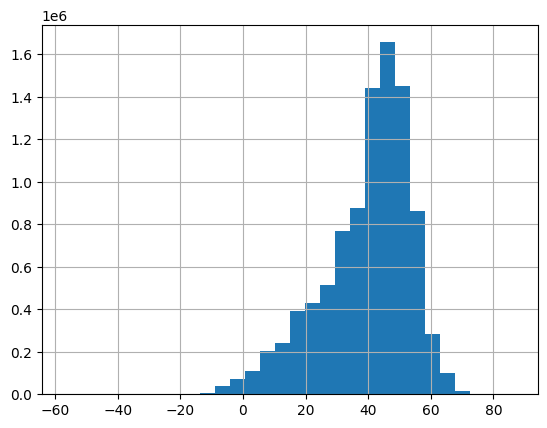

In [11]:
# Contact price bin distribution
stats.contact_price_bin.hist(bins=30)

In [12]:
def campaigns_value_counts(campaigns: pd.DataFrame):
    length_series = pd.to_datetime(campaigns['campaign_end'], unit='s') - pd.to_datetime(campaigns['campaign_start'], unit='s')
    print(length_series.value_counts())
    pass

In [13]:
# Distribution of the lengths of the lifetime of the campaigns
campaigns_value_counts(campaigns)

1 days     8499
3 days      536
2 days      419
5 days      391
7 days      390
4 days       47
6 days        6
8 days        3
14 days       3
10 days       2
Name: count, dtype: int64


# Train + test split

In [14]:
minicampaigns.campaign_start_date.value_counts()

campaign_start_date
1986-10-14    924
1986-10-13    904
1986-10-15    861
1986-10-16    840
1986-10-20    757
1986-10-17    750
1986-10-21    728
1986-10-18    647
1986-10-23    624
1986-10-24    606
1986-10-19    590
1986-10-25    494
1986-10-22    461
1986-10-26    437
1986-10-12     17
Name: count, dtype: int64

In [15]:
k = len(minicampaigns) * 2 // 15
k_test = len(minicampaigns) * 4 // 15
last_train_start = max(np.partition(minicampaigns.campaign_start, k)[:k])
last_test_start = max(np.partition(minicampaigns.campaign_start, k_test)[:k_test])
print(f'length of the train: {k}, length of the test: {k_test - k}')

length of the train: 1285, length of the test: 1285


In [16]:
len(minicampaigns[minicampaigns.campaign_start < last_train_start]), len(minicampaigns[(minicampaigns.campaign_start >= last_train_start) & (minicampaigns.campaign_start < last_test_start)])

(1284, 1285)

In [17]:
# Filter out campaigns from the training set whose lifetimes intersect with any campaign in the test set
campaigns_train = minicampaigns[minicampaigns.campaign_start < last_train_start]
campaigns_test = minicampaigns[(minicampaigns.campaign_start >= last_train_start) & (minicampaigns.campaign_start < last_test_start)]

# Saving filtered data to files

In [19]:
minicampaigns.to_csv('../data/fpa/campaigns_fpa_filtered_final.csv', index=False)
campaigns_train.to_csv('../data/fpa/campaigns_fpa_filtered_train_final.csv', index=False)
campaigns_test.to_csv('../data/fpa/campaigns_fpa_filtered_test_final.csv', index=False)

In [20]:
ministats.to_csv('../data/fpa/stats_fpa_filtered_final.csv', index=False)
ministats[ministats.campaign_id.isin(campaigns_train.campaign_id)].to_csv('../data/fpa/stats_fpa_filtered_train_final.csv', index=False)
ministats[ministats.campaign_id.isin(campaigns_test.campaign_id)].to_csv('../data/fpa/stats_fpa_filtered_test_final.csv', index=False)